In [4]:
!pip install -U nilearn

Requirement already up-to-date: nilearn in /usr/local/lib/python3.6/dist-packages (0.4.2)
Requirement not upgraded as not directly required: nibabel>=2.0.2 in /usr/local/lib/python3.6/dist-packages (from nilearn) (2.3.0)


In [0]:
import warnings

import numpy as np
from scipy import stats
from sklearn.decomposition import FastICA

from nilearn import datasets
from nilearn.image import smooth_img

from nilearn.datasets import load_mni152_brain_mask
from nilearn.input_data import NiftiMasker

from nilearn import plotting

from nilearn.datasets import fetch_neurovault
from nilearn.datasets.neurovault import basic_collection_terms, NotNull

In [6]:
print("Fetching Neurovault images; "
      "if you haven't downloaded any Neurovault data before "
      "this will take several minutes.")
nv_data = fetch_neurovault(max_images=250, collection_terms=dict(basic_collection_terms(), DOI=NotNull()), fetch_neurosynth_words=True)

Fetching Neurovault images; if you haven't downloaded any Neurovault data before this will take several minutes.
Reading local neurovault data.
Already fetched 1 image
Already fetched 2 images
Already fetched 3 images
Already fetched 4 images
Already fetched 5 images
Already fetched 6 images
Already fetched 7 images
Already fetched 8 images
Already fetched 9 images
Already fetched 10 images
Already fetched 11 images
Already fetched 12 images
Already fetched 13 images
Already fetched 14 images
Already fetched 15 images
Already fetched 16 images
Already fetched 17 images
Already fetched 18 images
Already fetched 19 images
Already fetched 20 images
Already fetched 21 images
Already fetched 22 images
Already fetched 23 images
Already fetched 24 images
Already fetched 25 images
Already fetched 26 images
Already fetched 27 images
Already fetched 28 images
Already fetched 29 images
Already fetched 30 images
Already fetched 31 images
Already fetched 32 images
Already fetched 33 images
Already 

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError


Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9049.json
Could not fetch words for image 9049
Already fetched 180 images


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError


Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9051.json
Could not fetch words for image 9051
Already fetched 181 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9034.json
Could not fetch words for image 9034
Already fetched 182 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9041.json
Could not fetch words for image 9041


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError


Already fetched 183 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9039.json
Could not fetch words for image 9039
Already fetched 184 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9052.json
Could not fetch words for image 9052
Already fetched 185 images


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError


Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9038.json
Could not fetch words for image 9038
Already fetched 186 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9048.json
Could not fetch words for image 9048
Already fetched 187 images


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError


Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9040.json
Could not fetch words for image 9040
Already fetched 188 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9036.json
Could not fetch words for image 9036
Already fetched 189 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9047.json
Could not fetch words for image 9047
Already fetched 190 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9042.json
Could not fetch words for image 9042
Already fetched 191 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9045.json
Could not fetch words for image 9045


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError


Already fetched 192 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9046.json
Could not fetch words for image 9046
Already fetched 193 images


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError


Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9043.json
Could not fetch words for image 9043
Already fetched 194 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9050.json
Could not fetch words for image 9050
Already fetched 195 images


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError


Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9037.json
Could not fetch words for image 9037
Already fetched 196 images
Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9044.json
Could not fetch words for image 9044
Already fetched 197 images


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/nilearn/datasets/neurovault.py", line 1577, in _download_image_terms
    assert _check_has_words(image_info['ns_words_absolute_path'])
AssertionError


Download succeeded, downloaded to: /content/nilearn_data/neurovault/collection_555/neurosynth_words_for_image_9053.json
Could not fetch words for image 9053
Already fetched 198 images
Already fetched 199 images
Already fetched 200 images
Already fetched 201 images
Already fetched 202 images
Already fetched 203 images
Already fetched 204 images
Already fetched 205 images
Already fetched 206 images
Already fetched 207 images
Already fetched 208 images
Already fetched 209 images
Already fetched 210 images
Already fetched 211 images
Already fetched 212 images
Already fetched 213 images
Already fetched 214 images
Already fetched 215 images
Already fetched 216 images
Already fetched 217 images
Already fetched 218 images
Already fetched 219 images
Already fetched 220 images
Already fetched 221 images
Already fetched 222 images
Already fetched 223 images
Already fetched 224 images
Already fetched 225 images
Already fetched 226 images
Already fetched 227 images
Already fetched 228 images
Alread

In [7]:
images = nv_data['images']
term_weights = nv_data['word_frequencies']
vocabulary = nv_data['vocabulary']

# Clean and report term scores
term_weights[term_weights < 0] = 0
total_scores = np.mean(term_weights, axis=0)

print("\nTop 10 neurosynth terms from downloaded images:\n")

for term_idx in np.argsort(total_scores)[-10:][::-1]:
    print(vocabulary[term_idx])


Top 10 neurosynth terms from downloaded images:

sentences
sentence
temporal
comprehension
language
temporal sulcus
superior temporal
linguistic
middle temporal
temporal gyrus


In [8]:
print("\nReshaping and masking images.\n")

with warnings.catch_warnings():
    warnings.simplefilter('ignore', UserWarning)
    warnings.simplefilter('ignore', DeprecationWarning)

    mask_img = load_mni152_brain_mask()
    masker = NiftiMasker(
        mask_img=mask_img, memory='nilearn_cache', memory_level=1)
    masker = masker.fit()

    # Images may fail to be transformed, and are of different shapes,
    # so we need to transform one-by-one and keep track of failures.
    X = []
    is_usable = np.ones((len(images),), dtype=bool)

    for index, image_path in enumerate(images):
        # load image and remove nan and inf values.
        # applying smooth_img to an image with fwhm=None simply cleans up
        # non-finite values but otherwise doesn't modify the image.
        image = smooth_img(image_path, fwhm=None)
        try:
            X.append(masker.transform(image))
        except Exception as e:
            meta = nv_data['images_meta'][index]
            print("Failed to mask/reshape image: id: {0}; "
                  "name: '{1}'; collection: {2}; error: {3}".format(
                      meta.get('id'), meta.get('name'),
                      meta.get('collection_id'), e))
            is_usable[index] = False

# Now reshape list into 2D matrix, and remove failed images from terms
X = np.vstack(X)
term_weights = term_weights[is_usable, :]


Reshaping and masking images.



In [9]:
!pip install -U umap-learn

Requirement not upgraded as not directly required: scikit-learn>=0.16 in /usr/local/lib/python3.6/dist-packages (from umap-learn) (0.19.1)
Requirement not upgraded as not directly required: scipy>=0.19 in /usr/local/lib/python3.6/dist-packages (from umap-learn) (0.19.1)
    100% |████████████████████████████████| 1.9MB 6.9MB/s 
Requirement not upgraded as not directly required: numpy>=1.8.2 in /usr/local/lib/python3.6/dist-packages (from scipy>=0.19->umap-learn) (1.14.5)
    100% |████████████████████████████████| 15.8MB 2.7MB/s 
  Running setup.py bdist_wheel for umap-learn ... - done
  Stored in directory: /content/.cache/pip/wheels/f3/e1/4b/1f9a0c2f9b82523b261c36c6ce9a4d1524582e03ebbf6852d6
Successfully built umap-learn


In [0]:
import umap

In [0]:
embedding = umap.UMAP(n_neighbors=5,min_dist=0.3,metric='correlation').fit_transform(X)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

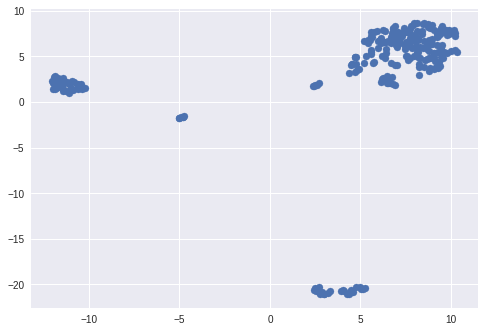

In [13]:
plt.scatter(embedding[:,0], embedding[:,1])

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_transform(embedding)

In [0]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = embedding[:, 0].min() - 1, embedding[:, 0].max() + 1
y_min, y_max = embedding[:, 1].min() - 1, embedding[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [0]:
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

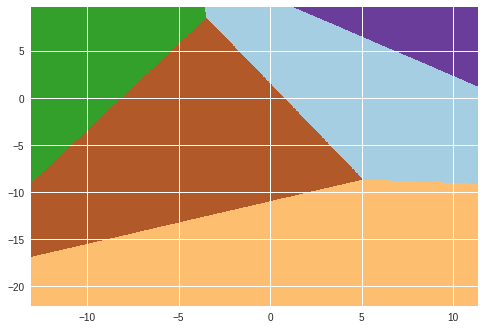

In [17]:
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

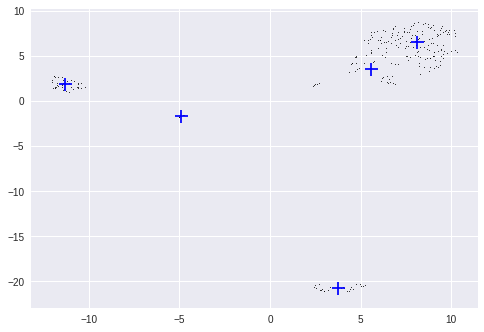

In [18]:
plt.plot(embedding[:, 0], embedding[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=169, linewidths=3,
            color='b', zorder=10)

In [0]:
from sklearn.neighbors import LocalOutlierFactor


clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(embedding)
y_pred_outliers = y_pred[200:]

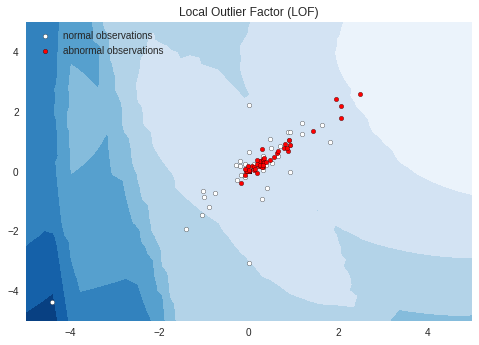

In [34]:
xx1, yy1 = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z1 = clf._decision_function(np.c_[xx1.ravel(), yy1.ravel()])
Z1 = Z1.reshape(xx1.shape)

plt.title("Local Outlier Factor (LOF)")
plt.contourf(xx1, yy1, Z1, cmap=plt.cm.Blues_r)

a = plt.scatter(X[:200, 0], X[:200, 1], c='white',
                edgecolor='k', s=20)
b = plt.scatter(X[200:, 0], X[200:, 1], c='red',
                edgecolor='k', s=20)
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")
plt.show()